# FINAL PROJECT COMP 6600<br> EGG CLASSIFICATION MODEL

In [2]:
# Step 1 - Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Step 2 - Imports + Initial setup
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [4]:
# Step 3 - Data Loading and Preprocessing (With Class Table Output)
IMG_SIZE = 224
BATCH_SIZE = 64

train_dir = '/content/drive/MyDrive/data/train'
val_dir = '/content/drive/MyDrive/data/val'
test_dir = '/content/drive/MyDrive/data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=20,
    zoom_range=0.2, horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_gen = val_test_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
test_gen = val_test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

# Show class mapping
class_df = pd.DataFrame(list(train_gen.class_indices.items()), columns=["Class Name", "Class Index"])
print("Class Index Mapping:")
display(class_df)

Found 1200 images belonging to 4 classes.
Found 150 images belonging to 4 classes.
Found 150 images belonging to 4 classes.
Class Index Mapping:


,Class Name,Class Index
0,cracked,0
1,cracked and dirty,1
2,dirty,2
3,healthy,3


In [5]:
# Step 4 - Base VGG19 Model (Frozen)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
# Step 5 - Train the Base Model
from sklearn.utils import class_weight

# Get labels from train_gen
labels = train_gen.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights = dict(enumerate(class_weights))

history_base = model.fit(train_gen, validation_data=val_gen, class_weight=class_weights, epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1203s 63s/step - accuracy: 0.2674 - loss: 1.5942 - val_accuracy: 0.2533 - val_loss: 1.4917
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1093s 58s/step - accuracy: 0.2471 - loss: 1.6669 - val_accuracy: 0.2800 - val_loss: 1.4700
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1103s 58s/step - accuracy: 0.2291 - loss: 1.6372 - val_accuracy: 0.3000 - val_loss: 1.4515
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1078s 57s/step - accuracy: 0.2543 - loss: 1.5658 - val_accuracy: 0.3267 - val_loss: 1.4369
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1096s 57s/step - accuracy: 0.2464 - loss: 1.6102 - val_accuracy: 0.3600 - val_loss: 1.4230
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1096s 58s/step - accuracy: 0.2561 - loss: 1.5490 - val_accuracy: 0.4067 - val_loss: 1.4124
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1068s 57s/step - accuracy: 0.2602 - loss: 1.5542 - val_accuracy: 0.4267 - val_loss: 1.4027
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1074s 57s/step - accuracy: 0.2446 - loss: 1.5814 - val_accu

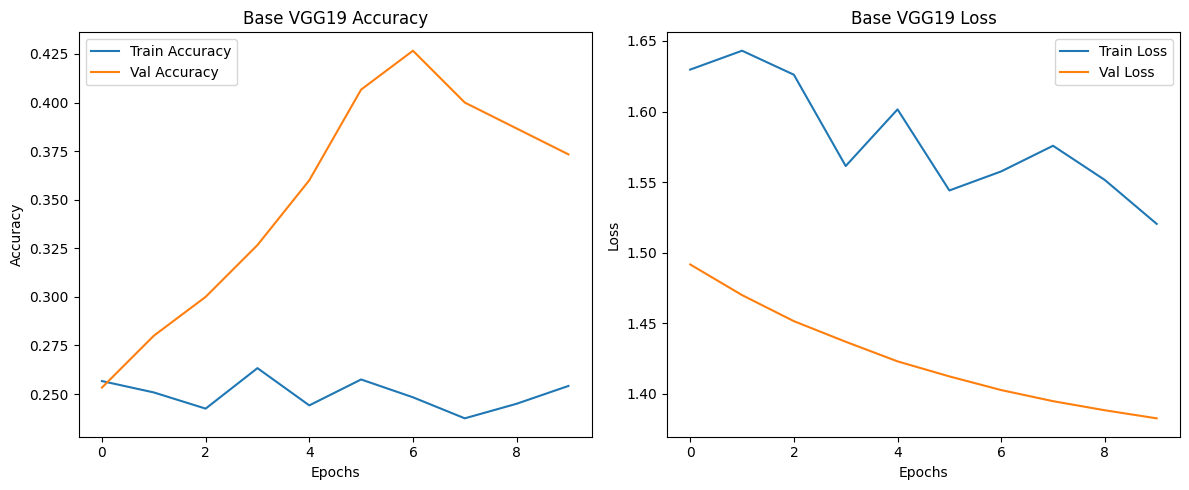

In [7]:
# Step 6 - Plot Training History
def plot_history(history, title='Model'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_base, "Base VGG19")

3/3 ━━━━━━━━━━━━━━━━━━━━ 118s 34s/step - accuracy: 0.3111 - loss: 1.4204
Test Accuracy (Base VGG19): 0.38
3/3 ━━━━━━━━━━━━━━━━━━━━ 116s 33s/step


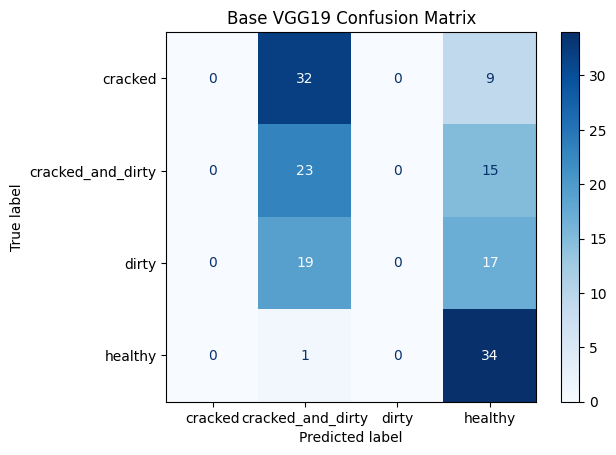

Classification Report (Base VGG19):
                   precision    recall  f1-score   support

          cracked       0.00      0.00      0.00        41
cracked_and_dirty       0.31      0.61      0.41        38
            dirty       0.00      0.00      0.00        36
          healthy       0.45      0.97      0.62        35

         accuracy                           0.38       150
        macro avg       0.19      0.39      0.26       150
     weighted avg       0.18      0.38      0.25       150



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Step 7 - Evaluate Base Model (Confusion Matrix & Report)
loss_base, acc_base = model.evaluate(test_gen)
print(f"Test Accuracy (Base VGG19): {acc_base:.2f}")

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Base VGG19 Confusion Matrix")
plt.show()

print("Classification Report (Base VGG19):")
print(classification_report(y_true, y_pred, target_names=labels))

In [10]:
# Step 8 - Fine-Tune VGG19 (Unfreeze Last Convolution Block)
# Unfreeze last 4 convolutional layers
for layer in base_model.layers[-8:]:
    layer.trainable = True

# Recompile the model (necessary after changing trainable layers)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train again
history_ft = model.fit(train_gen, validation_data=val_gen, epochs=5)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1629s 86s/step - accuracy: 0.2776 - loss: 1.4874 - val_accuracy: 0.6800 - val_loss: 1.2105
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1662s 87s/step - accuracy: 0.4341 - loss: 1.2538 - val_accuracy: 0.7067 - val_loss: 0.9017
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1622s 85s/step - accuracy: 0.6354 - loss: 0.9215 - val_accuracy: 0.7400 - val_loss: 0.6377
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1639s 85s/step - accuracy: 0.6900 - loss: 0.7827 - val_accuracy: 0.8133 - val_loss: 0.4867
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 1620s 86s/step - accuracy: 0.7252 - loss: 0.6254 - val_accuracy: 0.8733 - val_loss: 0.3986


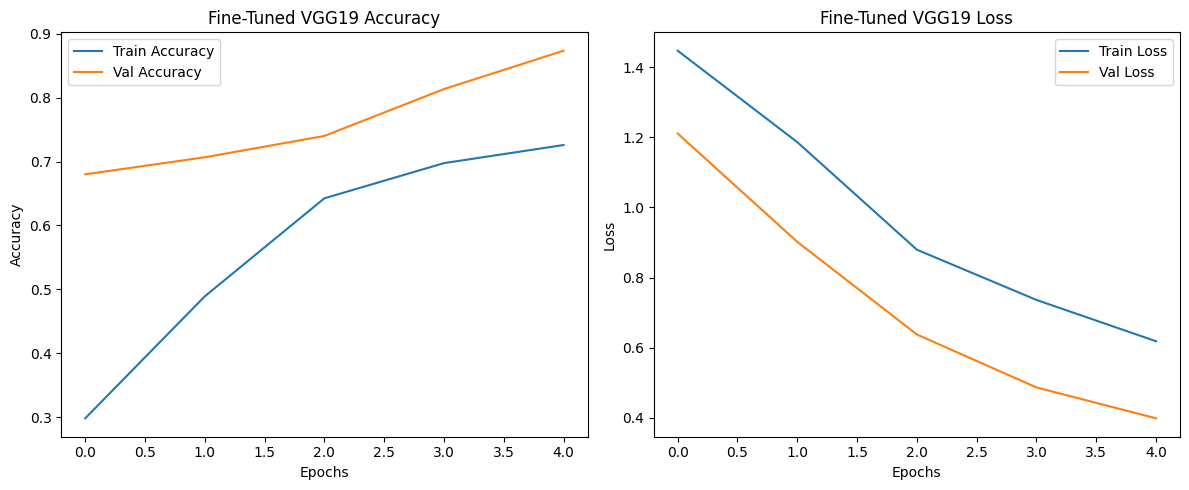

In [11]:
# Step 9 - Plot Fine-Tuning History & Compare
plot_history(history_ft, "Fine-Tuned VGG19")

3/3 ━━━━━━━━━━━━━━━━━━━━ 119s 35s/step - accuracy: 0.8653 - loss: 0.3845
Test Accuracy (Fine-Tuned VGG19): 0.84
3/3 ━━━━━━━━━━━━━━━━━━━━ 117s 33s/step


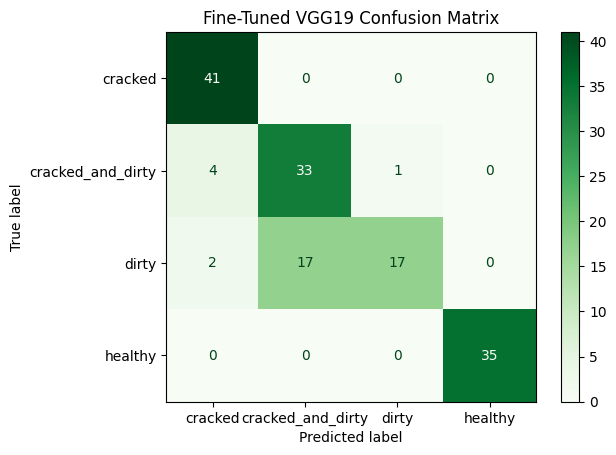

Classification Report (Fine-Tuned VGG19):
                   precision    recall  f1-score   support

          cracked       0.87      1.00      0.93        41
cracked_and_dirty       0.66      0.87      0.75        38
            dirty       0.94      0.47      0.63        36
          healthy       1.00      1.00      1.00        35

         accuracy                           0.84       150
        macro avg       0.87      0.84      0.83       150
     weighted avg       0.87      0.84      0.83       150



In [12]:
# Step 10 - Evaluate Fine-Tuned Model
loss_ft, acc_ft = model.evaluate(test_gen)
print(f"Test Accuracy (Fine-Tuned VGG19): {acc_ft:.2f}")

y_pred_ft = np.argmax(model.predict(test_gen), axis=1)

cm_ft = confusion_matrix(y_true, y_pred_ft)
disp = ConfusionMatrixDisplay(cm_ft, display_labels=labels)
disp.plot(cmap='Greens')
plt.title("Fine-Tuned VGG19 Confusion Matrix")
plt.show()

print("Classification Report (Fine-Tuned VGG19):")
print(classification_report(y_true, y_pred_ft, target_names=labels))

In [13]:
# Step 11 - Accuracy Improvement Summary
comparison_df = pd.DataFrame({
    "Model": ["Base VGG19", "Fine-Tuned VGG19"],
    "Test Accuracy": [acc_base, acc_ft]
})
print("Accuracy Comparison:")
display(comparison_df)

Accuracy Comparison:


,Model,Test Accuracy
0,Base VGG19,0.38
1,Fine-Tuned VGG19,0.84


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step

Image: 2contr.jpg (True: healthy)
cracked: 3.30%
cracked_and_dirty: 0.29%
dirty: 0.70%
healthy: 95.71%
Predicted Class: healthy (95.71%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step

Image: 36.jpg (True: cracked)
cracked: 85.86%
cracked_and_dirty: 4.32%
dirty: 5.36%
healthy: 4.47%
Predicted Class: cracked (85.86%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step

Image: 5ver.jpg (True: dirty)
cracked: 0.04%
cracked_and_dirty: 61.04%
dirty: 38.81%
healthy: 0.11%
Predicted Class: cracked_and_dirty (61.04%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step

Image: 14hor.jpg (True: cracked_and_dirty)
cracked: 4.78%
cracked_and_dirty: 59.28%
dirty: 34.38%
healthy: 1.56%
Predicted Class: cracked_and_dirty (59.28%)


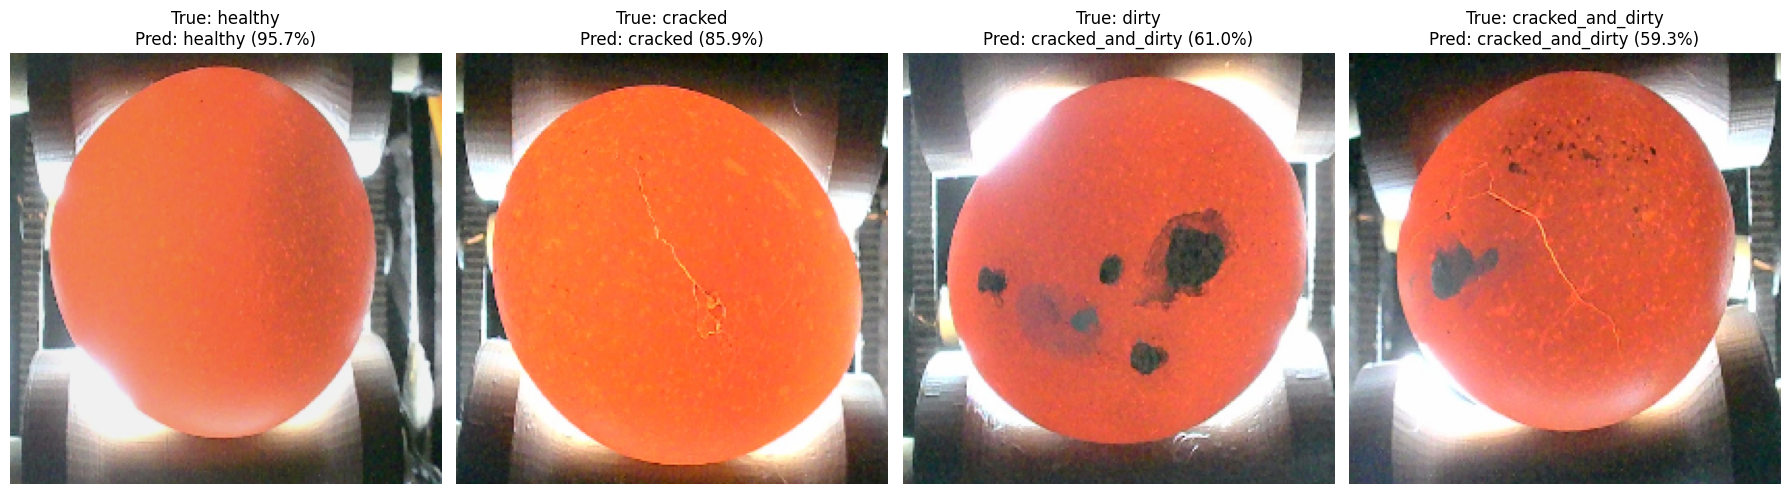

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input

# Paths to one image per class (adjust names as needed)
test_image_paths = {
    'healthy': '/content/drive/MyDrive/data/test/healthy/2contr.jpg',
    'cracked': '/content/drive/MyDrive/data/test/cracked/36.jpg',
    'dirty': '/content/drive/MyDrive/data/test/dirty/5ver.jpg',
    'cracked_and_dirty': '/content/drive/MyDrive/data/test/cracked_and_dirty/14hor.jpg'
}

# Fetch class names
class_names = list(test_gen.class_indices.keys())

# Prepare plot
fig, axes = plt.subplots(1, len(test_image_paths), figsize=(18, 6))

for i, (true_label, img_path) in enumerate(test_image_paths.items()):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_display = img_array.astype('uint8')
    img_array = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array / 255.0

    # Predict
    prediction = model.predict(img_preprocessed)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = prediction[0][predicted_index] * 100

    # Print prediction scores
    print(f"\nImage: {os.path.basename(img_path)} (True: {true_label})")
    for j, class_name in enumerate(class_names):
        print(f"{class_name}: {prediction[0][j]*100:.2f}%")
    print(f"Predicted Class: {predicted_class} ({confidence:.2f}%)")

    # Show image with prediction
    axes[i].imshow(img_display)
    axes[i].set_title(f"True: {true_label}\nPred: {predicted_class} ({confidence:.1f}%)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


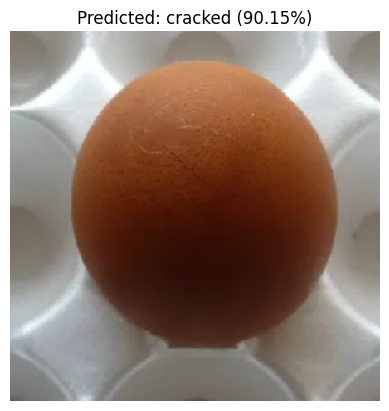

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Define the image path
random_image_path = '/content/drive/MyDrive/random_egg.jpg'  # Adjust path if needed

# Load and preprocess the image
img = image.load_img(random_image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_preprocessed = img_array / 255.0  # Match training preprocessing

# Predict
prediction = model.predict(img_preprocessed)

# Get class names from test generator
class_names = list(test_gen.class_indices.keys())

# Get predicted class
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]
confidence = np.max(prediction)

# Show image with prediction
plt.imshow(img_array[0].astype('uint8'))
plt.title(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")
plt.axis('off')
plt.show()
